## Runs Scored - Model Evaluation
- ### Last time we built a model to predict runs scored given features about the hitting team and the opposing pitchers
- ### In this lesson we will use that model to predict the probability that the total runs scored is over or under the "over/under line" for each game in the test set
- ### This first attempt involves an independence assumption which is likely not true in practice, but may be close enough to true to give good predictions
- ### We will then evaluate how this model would have fared in practice had we made bets on it, and do some further analysis to see if we really have an edge on the Vegas probabilities for the over/under

In [1]:
## Upgrade to the latest version of structureboost
## should be >= 0.4.1
## !pip install --upgrade structureboost 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [3]:
stb.__version__

'0.4.1'

In [4]:
df=pd.read_csv('df_bp9.csv')
df_runs=pd.read_csv('df_runs_bp11.csv')

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (13,14,15,19,85,87,159,206) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.over_under_line.max()

15.0

In [6]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

In [7]:
df_train = df_runs[(df_runs.season>1980) & (df_runs.season<=2018) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2019) & (df_runs.season<=2020)]
df_test = df_runs[df_runs.season>=2021]

In [8]:
df_test_game = df[df.season>=2021]

## Begin Modeling

In [9]:
df_runs.head()

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc
0,1980,19800409,0,198004090,SEA,TOR,AL,AL,0.0,NaN,SEA02,N,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258957,0.244999,0.261081,0.248690,0.316389,0.299753,0.318195,0.303498,0.391599,0.366607,0.393452,0.371455,0.707988,0.666360,0.711647,0.674953,0.302610,0.283802,0.301660,0.285333,0.103902,0.099765,0.103370,0.099810,0.247605,0.241513,0.247225,0.241943,0.302829,0.293223,0.301952,0.293652,0.357380,0.344445,0.356761,0.345529,0.660209,0.637667,0.658713,0.639181,0.277352,0.272526,0.275707,0.271654,0.101148,0.107454,0.100206,0.105801,0.236959,0.232164,0.235594,0.231540,0.293375,0.284567,0.291567,0.284053,0.341385,0.330441,0.339080,0.329750,0.634760,0.615009,0.630646,0.613803,0.271778,0.267889,0.269267,0.266116,0.101146,0.108100,0.099922,0.106111,0.207199,0.203860,0.206608,0.203750,0.259931,0.254701,0.258950,0.254479,0.296881,0.288656,0.295494,0.288449,0.556812,0.543357,0.554444,0.542928,0.243524,0.242021,0.241553,0.240432,0.092185,0.098451,0.091244,0.096804,5.692771,1.572289,0.104418,0.349398,0.502008,5.186747,1.152610,3.857143,1.357945,0.115165,0.321551,0.434436,4.040128,0.956670,4.644315,1.460641,0.098187,0.336354,0.459215,4.723032,1.087613,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1,8
1,1980,19800409,0,198004090,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291169,0.266224,0.291499,0.269692,0.358840,0.326376,0.359266,0.330886,0.443534,

In [10]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [11]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [12]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [13]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4990192148502604
i=10, eval_set_loss = 2.495524528841559
i=20, eval_set_loss = 2.4930883144691935
i=30, eval_set_loss = 2.491326254878249
i=40, eval_set_loss = 2.4899476910775844
i=50, eval_set_loss = 2.488865655337549
i=60, eval_set_loss = 2.4881122345957767
i=70, eval_set_loss = 2.4875551629313724
i=80, eval_set_loss = 2.4867541553427266
i=90, eval_set_loss = 2.4861089626610164
i=100, eval_set_loss = 2.4856129551188397
i=110, eval_set_loss = 2.4852459601878563
i=120, eval_set_loss = 2.4848450037372696
i=130, eval_set_loss = 2.484570981189364
i=140, eval_set_loss = 2.4843866588982384
i=150, eval_set_loss = 2.48423577145035
i=160, eval_set_loss = 2.4841363963915764
i=170, eval_set_loss = 2.484191076760697
i=180, eval_set_loss = 2.4841887161870644
i=190, eval_set_loss = 2.4841880679643458
i=200, eval_set_loss = 2.4841601239822046
i=210, eval_set_loss = 2.484205814406579
Stopping early: low pt was 5 steps ago


In [14]:
preds_test = cr1.predict_distributions(X_test)

In [15]:
preds_test.log_loss(y_test)

2.4258100625716272

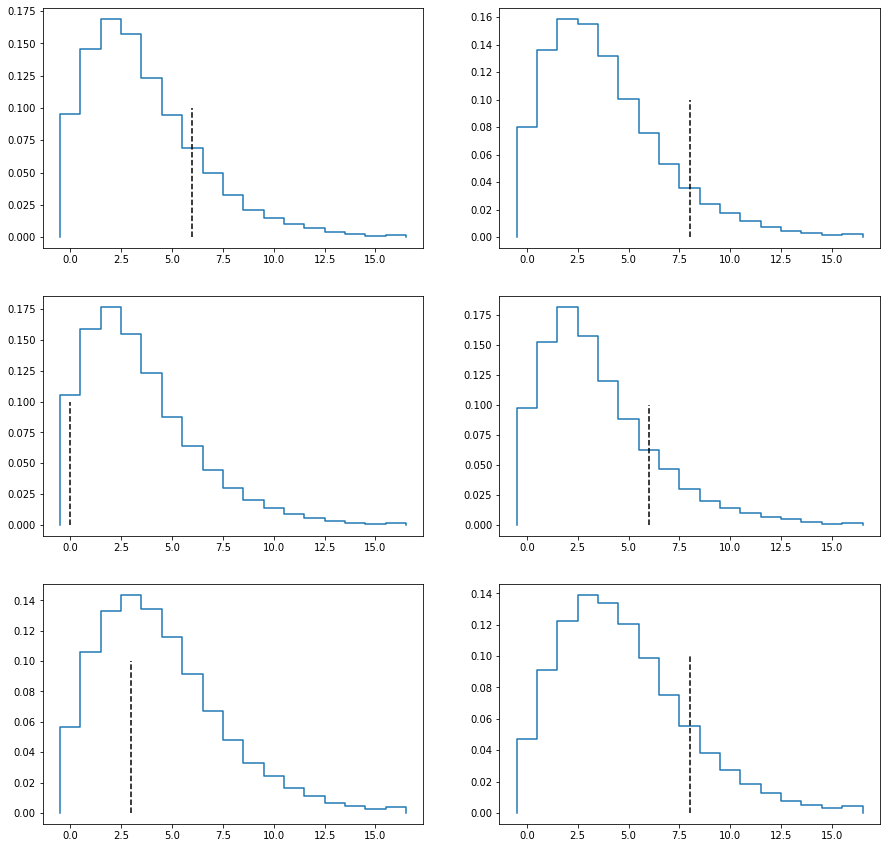

In [16]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.1, color='k', linestyle='--')

## Predicting the Over / Under
- ### As a first step, we will model the total score as an **independent** sum of the two scores
- ### For baseball, this is not a terrible assumption (would be worse in other sports)
- ### Still, would expect some imperfection, since teams make strategic decisions based on the score of the game
    - ### Play for one run in a close game
    - ### Put a rookie pitcher in with a big lead

In [17]:
def probs_oup_val(probvec_a, probvec_b, val, ties_go_over=True):
    """given two probability distributions and the ou-line, returns prob of under"""
    val_up = int(np.ceil(val))
    val_down = int(np.floor(val))
    cdf_b = np.cumsum(probvec_b)
    prob_under = 0
    prob_push = 0
    if (val_down<val_up): # This means we have a decimal (.5) o/u value - no pushes      
        for i in range(0, val_down+1):
            # calculate prob that we are less than or equal to val_down for each
            # value of probvec_a between 0 and val_down
            prob_under += probvec_a[i] * cdf_b[val_down-i]
        return(1-prob_under-prob_push, prob_under, prob_push)
    else: # This means val_down == val_up == val and we have an integer line so pushes are possible
        for i in range(0, val_down):
            # calculate prob that we are less than or equal to val_down-1 for each
            # value of probvec_a between 0 and val_down
            prob_under += probvec_a[i] * cdf_b[val_down-1-i]
        for j in range(0, val_down+1):
            # calculate prob that we are exactly = val_down
            if (not ties_go_over) or (j != val_down-j): # if line is 10 and predicts score of 5-5, maybe count as over
                prob_push += probvec_a[j] * probvec_b[val_down-j] 
        return(1-prob_under-prob_push, prob_under,  prob_push)

In [18]:
num_games_test=int(df_test.shape[0]/2)

In [19]:
oup_probs = np.array([probs_oup_val(preds_test[i].probvec, preds_test[i+num_games_test].probvec, df_test.over_under_line.iloc[i])
                        for i in range(num_games_test)])

In [20]:
oup_probs[:5,:]

array([[0.67348759, 0.32651241, 0.        ],
       [0.42308594, 0.47752091, 0.09939316],
       [0.2318583 , 0.70226633, 0.06587537],
       [0.4885844 , 0.41201151, 0.09940409],
       [0.4214188 , 0.5785812 , 0.        ]])

In [21]:
oup_probs.mean(axis=0)

array([0.44714768, 0.51160141, 0.04125091])

In [22]:
df_test.over_under_result.value_counts().sum(), df_test.over_under_result.value_counts()/df_test.over_under_result.value_counts().sum()

(9704,
 U    0.485573
 O    0.466818
 P    0.047609
 Name: over_under_result, dtype: float64)

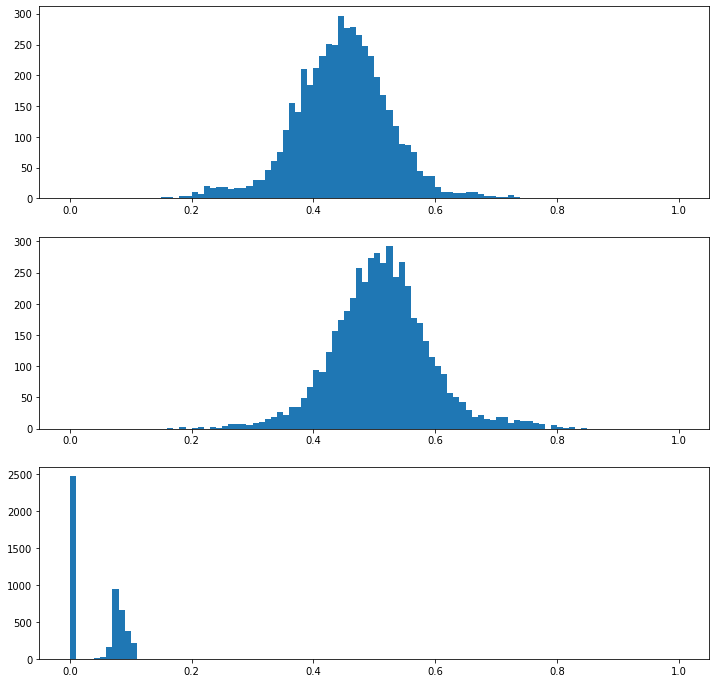

In [23]:
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.hist(oup_probs[:,0], np.linspace(0,1,101));
plt.subplot(3,1,2)
plt.hist(oup_probs[:,1], np.linspace(0,1,101));
plt.subplot(3,1,3)
plt.hist(oup_probs[:,2], np.linspace(0,1,101));

In [25]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')
    

In [26]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)


threshold = 0.25

There were 78 games that met criteria of edge > 0.25 (71 unders and 7 overs)
Of them 45 (0.577) were correct (winning bets), (41 unders and 4 overs) 
and 3 (0.038) were Pushes (2 unders and 1 overs)
and 30 (0.385) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.1538 per bet
	 for a total profit of 12.0 across all 78 bets


threshold = 0.2

There were 179 games that met criteria of edge > 0.2 (150 unders and 29 overs)
Of them 96 (0.536) were correct (winning bets), (81 unders and 15 overs) 
and 7 (0.039) were Pushes (6 unders and 1 overs)
and 76 (0.425) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0693 per bet
	 for a total profit of 12.4 across all 179 bets


threshold = 0.15

There were 355 games that met criteria of edge > 0.15 (280 unders and 75 overs)
Of them 182 (0.513) were correct (winning bets), (145 unders and 37 overs) 
and 18 (0.051) were Pushes (16 unders a

In [28]:
def evaluate_lkratio(nc, ni, null_prob, alt_prob):
    null_lk = sp.stats.binom.pmf(nc,nc+ni,null_prob)
    alt_lk = sp.stats.binom.pmf(nc,nc+ni,alt_prob)
    return(alt_lk/null_lk)

In [29]:
evaluate_lkratio(45, 30, .5, 45/(45+30))

4.527471049112594

In [30]:
evaluate_lkratio(96, 76, .5, 96/(96+76))

3.2072866107201

In [31]:
evaluate_lkratio(182, 155, .5, 182/(155+182))

2.95282544640109

In [32]:
evaluate_lkratio(489, 458, .5, 489/(489+458))

1.6611039651274728

In [33]:
evaluate_lkratio(450, 300, .5, 45/(45+30))

3618735.3177232626

## Conclusions
- ### Looks promising that our model *could* beat Vegas in the long run
- ### Would like to see higher likelihood ratios to have more confidence
- ### Let's repeat this notebook with more test data (less training data) to see if we can get more convicing evidence